# **House Price Prediction - Project Overview**

## **Group Members**
- Abdulla Razick (aar344@drexel.edu)
- Steven Sullivan (sas683@drexel.edu)
- Uditi Shah (us54@drexel.edu)

## **Objective**
This project aims to build a predictive model to estimate house prices based on historical data from Zillow Home Value Index (ZHVI). We use PySpark for data processing, exploratory data analysis (EDA), and machine learning (ML) to uncover trends and make accurate predictions.

## **Notebook Structure**
1. **Data Preprocessing**: 
   - Handling missing values
   - Data transformation (reshaping, feature engineering)
   
2. **Exploratory Data Analysis (EDA)**:
   - Analyzing historical home price trends across different regions.
   - Identifying seasonal patterns, regional variations, and correlations in the dataset.
   - Visualizing trends to guide feature selection for modeling.
   
3. **Machine Learning Models**:
   - Implementing three regression models: Linear Regression, Random Forest, and Gradient Boosting.
   - Evaluating model performance based on accuracy and interpretability.
   - Future directions and recommendations to improve models
   


# 1. Data Preprocessing

In [45]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import expr, col, sum, count, mean, median, first, last, when
from pyspark.sql.window import Window

In [47]:
spark = SparkSession.builder.appName("ZillowHomePrices").getOrCreate()

In [51]:
import os

file_path = os.path.expanduser("~/Desktop/Cloud Computing/projectdata/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

df = spark.read.csv(file_path, header=True, inferSchema=True)

In [53]:
# Get a list of all column names
columns_list = df.columns
print(columns_list)

['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', '2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30', '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31', '2000-09-30', '2000-10-31', '2000-11-30', '2000-12-31', '2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30', '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31', '2001-09-30', '2001-10-31', '2001-11-30', '2001-12-31', '2002-01-31', '2002-02-28', '2002-03-31', '2002-04-30', '2002-05-31', '2002-06-30', '2002-07-31', '2002-08-31', '2002-09-30', '2002-10-31', '2002-11-30', '2002-12-31', '2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30', '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31', '2003-09-30', '2003-10-31', '2003-11-30', '2003-12-31', '2004-01-31', '2004-02-29', '2004-03-31', '2004-04-30', '2004-05-31', '2004-06-30', '2004-07-31', '2004-08-31', '2004-09-30', '2004-10-31', '2004-11-30', '2004-12-31', '2005-01-31', '2005-02-28', '2005-03-31', '2005-04-30', '2005-05-31', '2005-06-30', '2005-07-3

In [55]:
#Converts dataset to contain date column and homevalue column for better viewing and analysis
id_columns = ["RegionID", "SizeRank", "RegionName", "RegionType", "StateName"]

date_columns = [col for col in df.columns if col not in id_columns]

df_long = df.selectExpr(
    "RegionID", "SizeRank", "RegionName", "RegionType", "StateName",
    "stack(" + str(len(date_columns)) + ", " +
    ", ".join([f"'{d}', `{d}`" for d in date_columns]) +
    ") as (Date, HomeValue)"
)

df_long = df_long.withColumn("Date", expr("to_date(Date, 'yyyy-MM-dd')"))


df_long.show(5)

+--------+--------+-------------+----------+---------+----------+------------------+
|RegionID|SizeRank|   RegionName|RegionType|StateName|      Date|         HomeValue|
+--------+--------+-------------+----------+---------+----------+------------------+
|  102001|       0|United States|   country|     NULL|2000-01-31|119729.57264043989|
|  102001|       0|United States|   country|     NULL|2000-02-29|119940.21534125193|
|  102001|       0|United States|   country|     NULL|2000-03-31|120201.44330529436|
|  102001|       0|United States|   country|     NULL|2000-04-30|120761.72601212111|
|  102001|       0|United States|   country|     NULL|2000-05-31|121406.54423448948|
+--------+--------+-------------+----------+---------+----------+------------------+
only showing top 5 rows



In [57]:
# Count null values for each column
null_counts = df_long.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_long.columns])

null_counts.show()

+--------+--------+----------+----------+---------+----+---------+
|RegionID|SizeRank|RegionName|RegionType|StateName|Date|HomeValue|
+--------+--------+----------+----------+---------+----+---------+
|       0|       0|         0|         0|      301|   0|    49266|
+--------+--------+----------+----------+---------+----+---------+



In [59]:
# Count non-null values for each column
non_null_counts = df_long.select(
    [count(col(c)).alias(c) for c in df_long.columns]
)

non_null_counts.show()

+--------+--------+----------+----------+---------+------+---------+
|RegionID|SizeRank|RegionName|RegionType|StateName|  Date|HomeValue|
+--------+--------+----------+----------+---------+------+---------+
|  269395|  269395|    269395|    269395|   269094|269395|   220129|
+--------+--------+----------+----------+---------+------+---------+



In [15]:
# Define window specification for FF
window_spec = Window.partitionBy("RegionID").orderBy("Date").rowsBetween(-1, 0)

# Apply Forward Fill 
df_long = df_long.withColumn("HomeValue", last("HomeValue", ignorenulls=True).over(window_spec))
df_long.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_long.columns]).show()

# Define window specification for BF 
window_spec_bf = Window.partitionBy("RegionID").orderBy("Date").rowsBetween(0, Window.unboundedFollowing)

# Apply Backward Fill 
df_long = df_long.withColumn("HomeValue", first("HomeValue", ignorenulls=True).over(window_spec_bf))
df_long.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_long.columns]).show()

+--------+--------+----------+----------+---------+----+---------+
|RegionID|SizeRank|RegionName|RegionType|StateName|Date|HomeValue|
+--------+--------+----------+----------+---------+----+---------+
|       0|       0|         0|         0|      301|   0|    49070|
+--------+--------+----------+----------+---------+----+---------+

+--------+--------+----------+----------+---------+----+---------+
|RegionID|SizeRank|RegionName|RegionType|StateName|Date|HomeValue|
+--------+--------+----------+----------+---------+----+---------+
|       0|       0|         0|         0|      301|   0|        0|
+--------+--------+----------+----------+---------+----+---------+



In [17]:
# Select RegionName and RegionID for rows where StateName is null
missing_state_df = df_long.filter(col("StateName").isNull()).select("RegionID", "RegionName")

missing_state_df.show(20, truncate=False)


+--------+-------------+
|RegionID|RegionName   |
+--------+-------------+
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
|102001  |United States|
+--------+-------------+
only showing top 20 rows



In [19]:
# Fill missing StateName for "United States" region
df_long = df_long.withColumn("StateName",
                             when(col("RegionName") == "United States", "National")
                             .otherwise(col("StateName")))

df_long.select(sum(col("StateName").isNull().cast("int")).alias("Missing_StateName")).show()


+-----------------+
|Missing_StateName|
+-----------------+
|                0|
+-----------------+



In [21]:
null_counts = df_long.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_long.columns])

null_counts.show()

+--------+--------+----------+----------+---------+----+---------+
|RegionID|SizeRank|RegionName|RegionType|StateName|Date|HomeValue|
+--------+--------+----------+----------+---------+----+---------+
|       0|       0|         0|         0|        0|   0|        0|
+--------+--------+----------+----------+---------+----+---------+



# 2. Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, avg, count

# Initialize Spark session
spark = SparkSession.builder.appName("HousePriceEDA").getOrCreate()

# Load cleaned dataset
file_path = "/content/cleaned_data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Show structure of data
df.printSchema()
df.show(5)

root
 |-- RegionID: integer (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- RegionName: string (nullable = true)
 |-- RegionType: string (nullable = true)
 |-- StateName: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- HomeValue: double (nullable = true)

+--------+--------+-------------+----------+---------+----------+------------------+
|RegionID|SizeRank|   RegionName|RegionType|StateName|      Date|         HomeValue|
+--------+--------+-------------+----------+---------+----------+------------------+
|  102001|       0|United States|   country| National|2000-01-31|119729.57264043989|
|  102001|       0|United States|   country| National|2000-02-29|119940.21534125193|
|  102001|       0|United States|   country| National|2000-03-31|120201.44330529436|
|  102001|       0|United States|   country| National|2000-04-30|120761.72601212111|
|  102001|       0|United States|   country| National|2000-05-31|121406.54423448948|
+--------+--------+-------------

In [ ]:
from pyspark.sql.functions import when

# Count missing values per column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+--------+--------+----------+----------+---------+----+---------+
|RegionID|SizeRank|RegionName|RegionType|StateName|Date|HomeValue|
+--------+--------+----------+----------+---------+----+---------+
|       0|       0|         0|         0|        0|   0|        0|
+--------+--------+----------+----------+---------+----+---------+



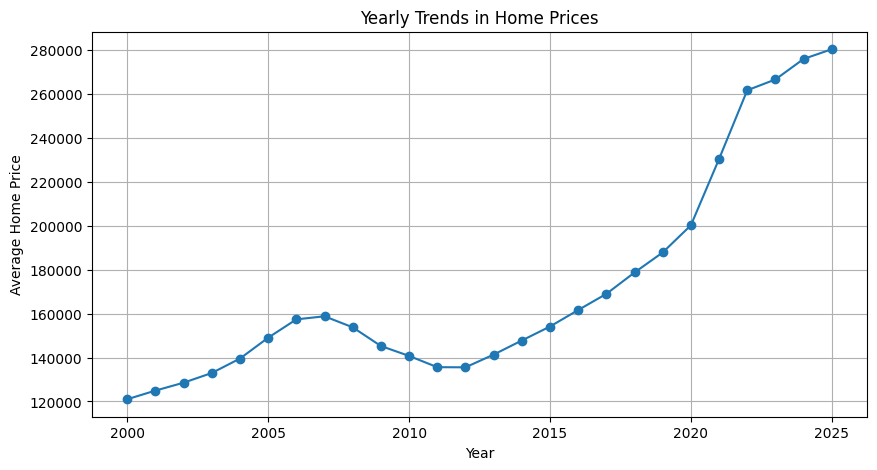

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Aggregate average home prices per year
yearly_trends = df.withColumn("Year", year(col("Date"))).groupBy("Year").agg(avg("HomeValue").alias("AvgHomePrice")).orderBy("Year")

# Convert to Pandas for visualization
yearly_trends_pd = yearly_trends.toPandas()

# Plot yearly home value trends
plt.figure(figsize=(10, 5))
plt.plot(yearly_trends_pd["Year"], yearly_trends_pd["AvgHomePrice"], marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Average Home Price")
plt.title("Yearly Trends in Home Prices")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql.functions import round, format_number

# Find the most expensive regions (latest year)
latest_year = df.agg({"Date": "max"}).collect()[0][0].year

# Compute average home price per region and round to the nearest 1,000
top_regions = (
    df.filter(year(col("Date")) == latest_year)
    .groupBy("RegionName")
    .agg(round(avg("HomeValue"), -3).alias("AvgHomePrice"))
    .orderBy(col("AvgHomePrice").desc())
)

# Format the AvgHomePrice column w commas
top_regions = top_regions.withColumn("AvgHomePrice", format_number(col("AvgHomePrice"), 0))

# Show top 10 regions
top_regions.show(10, truncate=False)

+---------------------+------------+
|RegionName           |AvgHomePrice|
+---------------------+------------+
|San Jose, CA         |1,612,000   |
|Vineyard Haven, MA   |1,479,000   |
|Jackson, WY          |1,418,000   |
|Edwards, CO          |1,310,000   |
|San Francisco, CA    |1,130,000   |
|Santa Cruz, CA       |1,120,000   |
|Heber, UT            |1,100,000   |
|Steamboat Springs, CO|1,078,000   |
|Kahului, HI          |1,043,000   |
|Key West, FL         |965,000     |
+---------------------+------------+
only showing top 10 rows



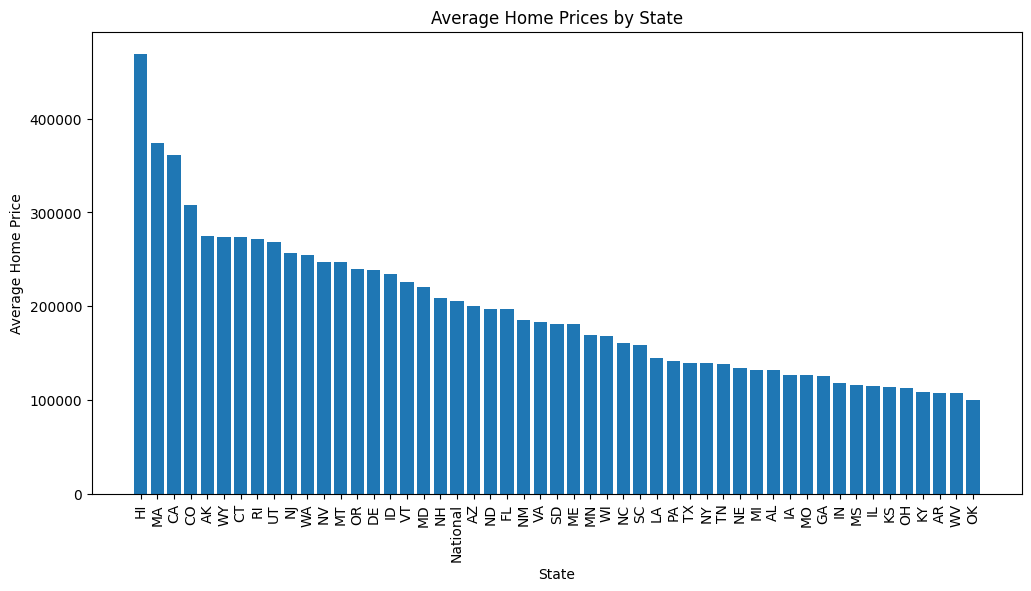

In [ ]:
# Average home price by state
statewise_prices = df.groupBy("StateName").agg(avg("HomeValue").alias("AvgHomePrice")).orderBy(col("AvgHomePrice").desc())

# Convert to Pandas for visualization
statewise_prices_pd = statewise_prices.toPandas()

# Plot bar chart of home prices by state
plt.figure(figsize=(12, 6))
plt.bar(statewise_prices_pd["StateName"], statewise_prices_pd["AvgHomePrice"])
plt.xticks(rotation=90)
plt.xlabel("State")
plt.ylabel("Average Home Price")
plt.title("Average Home Prices by State")
plt.show()

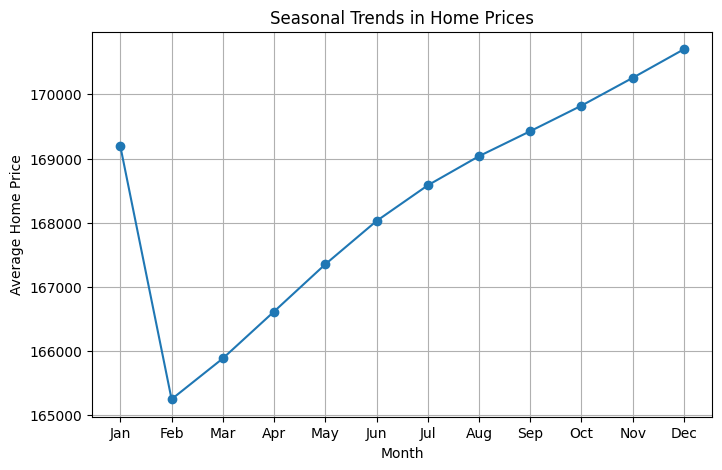

In [ ]:
# Extract month and compute average home values
monthly_trends = df.withColumn("Month", month(col("Date"))).groupBy("Month").agg(avg("HomeValue").alias("AvgHomePrice")).orderBy("Month")

# Convert to Pandas
monthly_trends_pd = monthly_trends.toPandas()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(monthly_trends_pd["Month"], monthly_trends_pd["AvgHomePrice"], marker='o', linestyle='-')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel("Month")
plt.ylabel("Average Home Price")
plt.title("Seasonal Trends in Home Prices")
plt.grid(True)
plt.show()

In [ ]:
from pyspark.sql.functions import corr, year

# Add a Year column extracted from Date
df = df.withColumn("Year", year(col("Date")))

# Compute correlation between home values and other numerical features
correlations = df.select(
    corr("HomeValue", "SizeRank").alias("HomeValue_SizeRank"),
    corr("HomeValue", "Year").alias("HomeValue_Year")
)

# Show correlation results
correlations.show()

+--------------------+------------------+
|  HomeValue_SizeRank|    HomeValue_Year|
+--------------------+------------------+
|-0.24895428077187107|0.3373296916165768|
+--------------------+------------------+



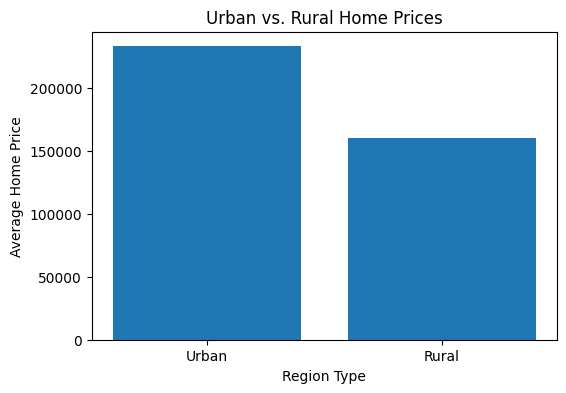

In [ ]:
# Classify as Urban or Rural based on SizeRank threshold
df = df.withColumn("Urban_Rural",
                   when(col("SizeRank") <= 100, "Urban").otherwise("Rural"))

# Compute average home prices for urban vs. rural areas
urban_rural_prices = df.groupBy("Urban_Rural").agg(avg("HomeValue").alias("AvgHomePrice"))

# Convert to Pandas for visualization
urban_rural_prices_pd = urban_rural_prices.toPandas()

# Plot Urban vs. Rural Home Prices
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.bar(urban_rural_prices_pd["Urban_Rural"], urban_rural_prices_pd["AvgHomePrice"])
plt.xlabel("Region Type")
plt.ylabel("Average Home Price")
plt.title("Urban vs. Rural Home Prices")
plt.show()

In [ ]:
# Calculate mean home prices for Urban and Rural areas
avg_prices = df.groupBy("Urban_Rural").agg(avg("HomeValue").alias("AvgHomePrice"))

# Convert to Pandas
avg_prices_pd = avg_prices.toPandas()

# Compute percentage increase
urban_price = avg_prices_pd[avg_prices_pd["Urban_Rural"] == "Urban"]["AvgHomePrice"].values[0]
rural_price = avg_prices_pd[avg_prices_pd["Urban_Rural"] == "Rural"]["AvgHomePrice"].values[0]

price_difference = ((urban_price - rural_price) / rural_price) * 100

print(f"Urban home prices are {price_difference:.2f}% higher than rural home prices.")

Urban home prices are 45.36% higher than rural home prices.


In [ ]:
from pyspark.sql.functions import corr

# Compute correlation values
correlation_values = df.select(
    corr("HomeValue", "SizeRank").alias("HomeValue_SizeRank"),
    corr("HomeValue", "Year").alias("HomeValue_Year")
).toPandas()

print(correlation_values)

   HomeValue_SizeRank  HomeValue_Year
0           -0.248954         0.33733


# 3. Machine Learning Models

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ZillowHomePrices").getOrCreate()

file_path = "/content/cleaned_data.csv"
df_cleaned = spark.read.csv(file_path, header=True, inferSchema=True)

df_cleaned.show(5)

+--------+--------+-------------+----------+---------+----------+------------------+
|RegionID|SizeRank|   RegionName|RegionType|StateName|      Date|         HomeValue|
+--------+--------+-------------+----------+---------+----------+------------------+
|  102001|       0|United States|   country| National|2000-01-31|119729.57264043989|
|  102001|       0|United States|   country| National|2000-02-29|119940.21534125193|
|  102001|       0|United States|   country| National|2000-03-31|120201.44330529436|
|  102001|       0|United States|   country| National|2000-04-30|120761.72601212111|
|  102001|       0|United States|   country| National|2000-05-31|121406.54423448948|
+--------+--------+-------------+----------+---------+----------+------------------+
only showing top 5 rows



In [ ]:
df_cleaned.printSchema()
print(df_cleaned.columns)

root
 |-- RegionID: integer (nullable = true)
 |-- SizeRank: integer (nullable = true)
 |-- RegionName: string (nullable = true)
 |-- RegionType: string (nullable = true)
 |-- StateName: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- HomeValue: double (nullable = true)

['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName', 'Date', 'HomeValue']


In [ ]:
from pyspark.sql.functions import year

# Add a Year column extracted from Date
df_cleaned = df_cleaned.withColumn("Year", year(col("Date")))

# Show the first few rows with the new Year column
df_cleaned.select("Date", "Year", "HomeValue").show(5)

+----------+----+------------------+
|      Date|Year|         HomeValue|
+----------+----+------------------+
|2000-01-31|2000|119729.57264043989|
|2000-02-29|2000|119940.21534125193|
|2000-03-31|2000|120201.44330529436|
|2000-04-30|2000|120761.72601212111|
|2000-05-31|2000|121406.54423448948|
+----------+----+------------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler

feature_columns = ["SizeRank", "Year"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

df_assembled = assembler.transform(df_cleaned)

df_assembled.select("features", "HomeValue").show(5)

+------------+------------------+
|    features|         HomeValue|
+------------+------------------+
|[0.0,2000.0]|119729.57264043989|
|[0.0,2000.0]|119940.21534125193|
|[0.0,2000.0]|120201.44330529436|
|[0.0,2000.0]|120761.72601212111|
|[0.0,2000.0]|121406.54423448948|
+------------+------------------+
only showing top 5 rows



In [ ]:
train_data, test_data = df_assembled.randomSplit([0.8, 0.2], seed=42)

print(f"Training Data Count: {train_data.count()}")
print(f"Test Data Count: {test_data.count()}")

Training Data Count: 215462
Test Data Count: 53933


In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol="features", labelCol="HomeValue")

lr_model = lr.fit(train_data)

lr_predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="HomeValue", predictionCol="prediction", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)
print(f"Linear Regression RMSE: {lr_rmse}")

Linear Regression RMSE: 100285.46526768184


In [ ]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="features", labelCol="HomeValue")

rf_model = rf.fit(train_data)

rf_predictions = rf_model.transform(test_data)

rf_rmse = evaluator.evaluate(rf_predictions)
print(f"Random Forest Regression RMSE: {rf_rmse}")

Random Forest Regression RMSE: 94970.69213840828


In [ ]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(featuresCol="features", labelCol="HomeValue")

gbt_model = gbt.fit(train_data)

gbt_predictions = gbt_model.transform(test_data)

gbt_rmse = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosting Regression RMSE: {gbt_rmse}")

Gradient Boosting Regression RMSE: 94468.23467366106


In [ ]:
print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest Regression RMSE: {rf_rmse}")
print(f"Gradient Boosting Regression RMSE: {gbt_rmse}")

Linear Regression RMSE: 100285.46526768184
Random Forest Regression RMSE: 94970.69213840828
Gradient Boosting Regression RMSE: 94468.23467366106


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Initialize evaluator for MAE
evaluator_mae = RegressionEvaluator(labelCol="HomeValue", predictionCol="prediction", metricName="mae")

# Calculate MAE for each model
lr_mae = evaluator_mae.evaluate(lr_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)
gbt_mae = evaluator_mae.evaluate(gbt_predictions)

print(f"Linear Regression MAE: {lr_mae}")
print(f"Random Forest Regression MAE: {rf_mae}")
print(f"Gradient Boosting Regression MAE: {gbt_mae}")

Linear Regression MAE: 63014.17860501716
Random Forest Regression MAE: 58910.90216345654
Gradient Boosting Regression MAE: 58686.07336220276


In [ ]:
# Initialize evaluator for R²
evaluator_r2 = RegressionEvaluator(labelCol="HomeValue", predictionCol="prediction", metricName="r2")

# Calculate R² for each model
lr_r2 = evaluator_r2.evaluate(lr_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

print(f"Linear Regression R²: {lr_r2}")
print(f"Random Forest Regression R²: {rf_r2}")
print(f"Gradient Boosting Regression R²: {gbt_r2}")

Linear Regression R²: 0.1787078413475759
Random Forest Regression R²: 0.2634522703469975
Gradient Boosting Regression R²: 0.27122529806502593


In [ ]:
import matplotlib.pyplot as plt

# Convert predictions to Pandas DataFrame
lr_predictions_pd = lr_predictions.select("HomeValue", "prediction").toPandas()
rf_predictions_pd = rf_predictions.select("HomeValue", "prediction").toPandas()
gbt_predictions_pd = gbt_predictions.select("HomeValue", "prediction").toPandas()

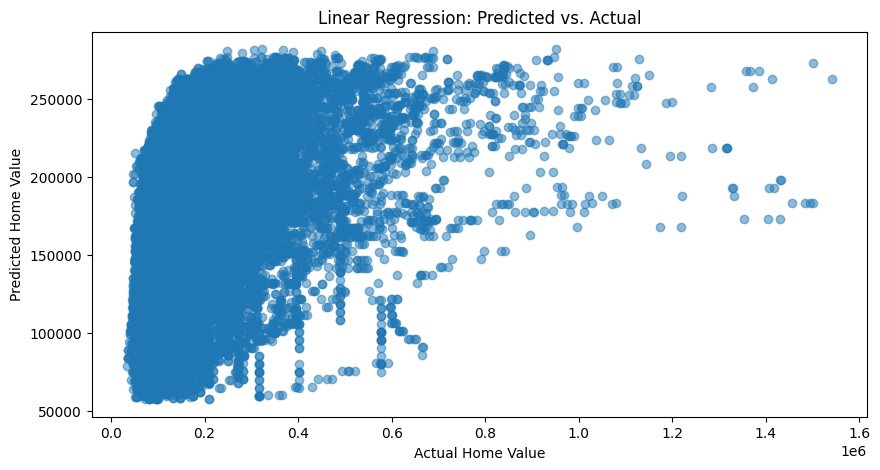

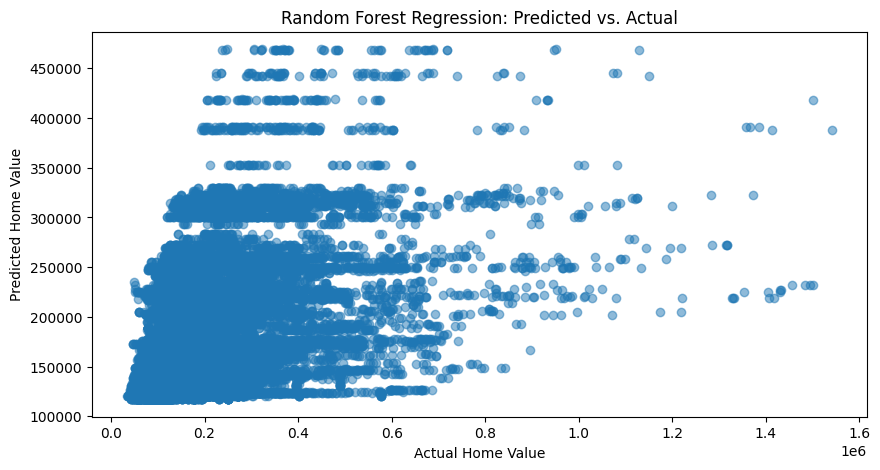

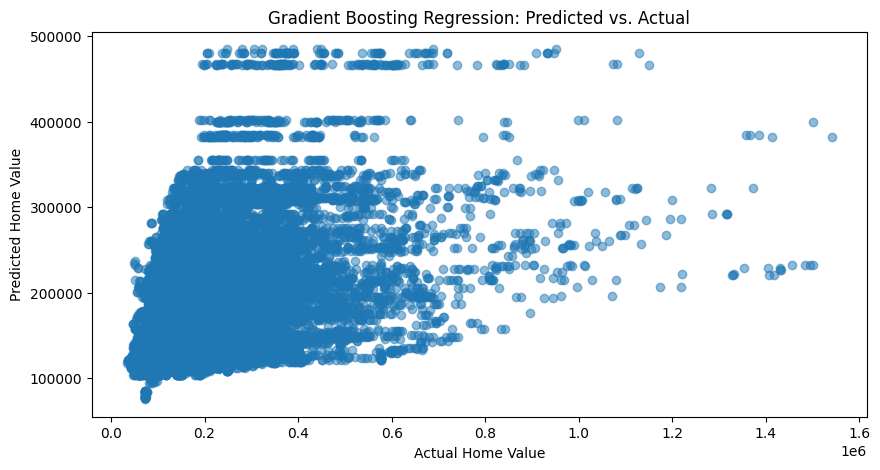

In [ ]:
# Plot for Linear Regression
plt.figure(figsize=(10, 5))
plt.scatter(lr_predictions_pd["HomeValue"], lr_predictions_pd["prediction"], alpha=0.5)
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Linear Regression: Predicted vs. Actual")
plt.show()

# Plot for Random Forest Regression
plt.figure(figsize=(10, 5))
plt.scatter(rf_predictions_pd["HomeValue"], rf_predictions_pd["prediction"], alpha=0.5)
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Random Forest Regression: Predicted vs. Actual")
plt.show()

# Plot for Gradient Boosting Regression
plt.figure(figsize=(10, 5))
plt.scatter(gbt_predictions_pd["HomeValue"], gbt_predictions_pd["prediction"], alpha=0.5)
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Gradient Boosting Regression: Predicted vs. Actual")
plt.show()

In [ ]:
# Make predictions on the training set
lr_train_predictions = lr_model.transform(train_data)
rf_train_predictions = rf_model.transform(train_data)
gbt_train_predictions = gbt_model.transform(train_data)

# Calculate training RMSE
lr_train_rmse = evaluator.evaluate(lr_train_predictions)
rf_train_rmse = evaluator.evaluate(rf_train_predictions)
gbt_train_rmse = evaluator.evaluate(gbt_train_predictions)

print(f"Linear Regression Training RMSE: {lr_train_rmse}")
print(f"Random Forest Regression Training RMSE: {rf_train_rmse}")
print(f"Gradient Boosting Regression Training RMSE: {gbt_train_rmse}")

Linear Regression Training RMSE: 100298.83074629487
Random Forest Regression Training RMSE: 95194.21526220225
Gradient Boosting Regression Training RMSE: 94624.45948897088


## Model Performance Analysis and Conclusion

## Model Performance Metrics

### RMSE (Root Mean Squared Error)
- **Linear Regression RMSE**: 100285.47
- **Random Forest Regression RMSE**: 94970.69
- **Gradient Boosting Regression RMSE**: 94468.23

### MAE (Mean Absolute Error)
- **Linear Regression MAE**: 63014.18
- **Random Forest Regression MAE**: 58910.90
- **Gradient Boosting Regression MAE**: 58686.07

### R² (R-Squared)
- **Linear Regression R²**: 0.1787
- **Random Forest Regression R²**: 0.2635
- **Gradient Boosting Regression R²**: 0.2712

### Training RMSE
- **Linear Regression Training RMSE**: 100298.83
- **Random Forest Regression Training RMSE**: 95194.22
- **Gradient Boosting Regression Training RMSE**: 94624.46

---

## Analysis of Results

### Model Performance
- **Gradient Boosting Regression** has the **lowest RMSE (94468.23)** and **lowest MAE (58686.07)**, indicating it makes the most accurate predictions on the test data.
- **Random Forest Regression** performs slightly worse than Gradient Boosting but better than Linear Regression.
- **Linear Regression** has the **highest RMSE (100285.47)** and **highest MAE (63014.18)**, indicating it is the least accurate.

### R² (Explained Variance)
- **Gradient Boosting Regression** has the **highest R² (0.2712)**, meaning it explains the most variance in the target variable (`HomeValue`).
- **Random Forest Regression** has a slightly lower R² (0.2635).
- **Linear Regression** has the **lowest R² (0.1787)**, indicating it explains the least variance.

### Overfitting
- The **training RMSE** values are very close to the **test RMSE** values for all models:
  - Linear Regression: Training RMSE ≈ Test RMSE
  - Random Forest Regression: Training RMSE ≈ Test RMSE
  - Gradient Boosting Regression: Training RMSE ≈ Test RMSE
- This suggests that **none of the models are overfitting** the training data.

### Visual Inspection (Predicted vs. Actual Plots)
- The scatter plots of **predicted vs. actual home values** show that:
  - **Gradient Boosting Regression** has the tightest clustering of points around the diagonal line, indicating better predictions.
  - **Random Forest Regression** also shows good clustering but slightly more spread than Gradient Boosting.
  - **Linear Regression** has the most spread, indicating less accurate predictions.

---

## Conclusion

### Best Model
**Gradient Boosting Regression** is the **best-performing model** based on:
- Lowest RMSE (94468.23)
- Lowest MAE (58686.07)
- Highest R² (0.2712)
- Best visual alignment of predicted vs. actual values.

### Second-Best Model
**Random Forest Regression** performs slightly worse than Gradient Boosting but significantly better than Linear Regression.

### Worst Model
**Linear Regression** performs the worst, as it has the highest RMSE, highest MAE, and lowest R². This is expected because Linear Regression is a simple model and may not capture the complex relationships in the data.

### Overfitting
None of the models show signs of overfitting, as the training and test RMSE values are very close.

---

## Recommendations

1. **Use Gradient Boosting Regression** for the final model, as it provides the best performance.
2. **Feature Engineering**:
   - Consider adding more features or transforming existing features to improve model performance.
   - For example, you could add features like:
     - Economic indicators (e.g., unemployment rate, interest rates).
     - Population growth or demographic data.
3. **Hyperparameter Tuning**:
   - Perform hyperparameter tuning for Gradient Boosting and Random Forest to further improve their performance.
4. **Interpretability**:
   - If interpretability is important, consider using Random Forest, as it is easier to interpret than Gradient Boosting.

---

## Summary Table

| Model                     | RMSE       | MAE       | R²        | Training RMSE | Overfitting? | Conclusion                     |
|---------------------------|------------|-----------|-----------|---------------|--------------|--------------------------------|
| Linear Regression         | 100285.47  | 63014.18  | 0.1787    | 100298.83     | No           | Least accurate                 |
| Random Forest Regression  | 94970.69   | 58910.90  | 0.2635    | 95194.22      | No           | Good, but worse than GBT       |
| Gradient Boosting Regression | 94468.23 | 58686.07  | 0.2712    | 94624.46      | No           | Best-performing model          |